Задание
Основные цели этого задания:

попрактиковаться в анализе временных рядов,

научиться извлекать дополнительные признаки для прогнозирования временного ряда,

проверять качество модели на отложенной выборке.

Задача: спрогнозировать число пассажиров авиакомпании помесячно.

План:

1. Загрузите данные из источника по ссылке, ознакомьтесь с ними и подготовьте к аналитике

1.1 Найдите и удалите пропуски, если они есть.
1.2  Поменяйте тип столбца с временными отсечками в datetime.

1.3  Установите индексом данных столбец с временными отсечками и убедитесь, что он монотонно возрастает.

In [134]:
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from statsmodels import api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose

pd.options.display.float_format = '{:.2f}'.format

In [135]:
data = pd.read_csv('AirPassengers.csv')
data.head().T

,0,1,2,3,4
Month,1949-01,1949-02,1949-03,1949-04,1949-05
#Passengers,112,118,132,129,121


In [136]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


1.1 Пропусков нет. 
1.2 Изменим тип данных столбца 'Month' на datetime64.

In [137]:
data['Month'] = pd.to_datetime(data['Month'], format="%Y-%m")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


1.3 Используем столбец 'Month' в качестве индексов

In [138]:
data.set_index('Month', inplace=True)
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [139]:
data.index.is_monotonic_increasing

True

2. Проанализируйте временной ряд

2.1 Оставьте для аналитики лишь с 1952 по 1957 год (включительно).

2.2 Реализуйте разложение на компоненты тренда и сезонности. Визуализируйте результат разложения и сделайте выводы.

2.2.1Есть ли тренд?

2.2.2 Есть ли сезонность и какая она (ежемесячная/ежеквартальная/ежегодная и т.д.)?

2.2.3 Является ли ряд стационарным и почему?

2.3 Постройте график, чтобы оценить автокорреляцию и сделайте выводы

2.3.1 У какого сдвига самая высокая автокорреляция?

2.3.2 Подтверждаются ли выводы о наличии т

In [140]:
df = data['1952':'1957']

In [141]:
decomposed = seasonal_decompose(df['#Passengers']) 

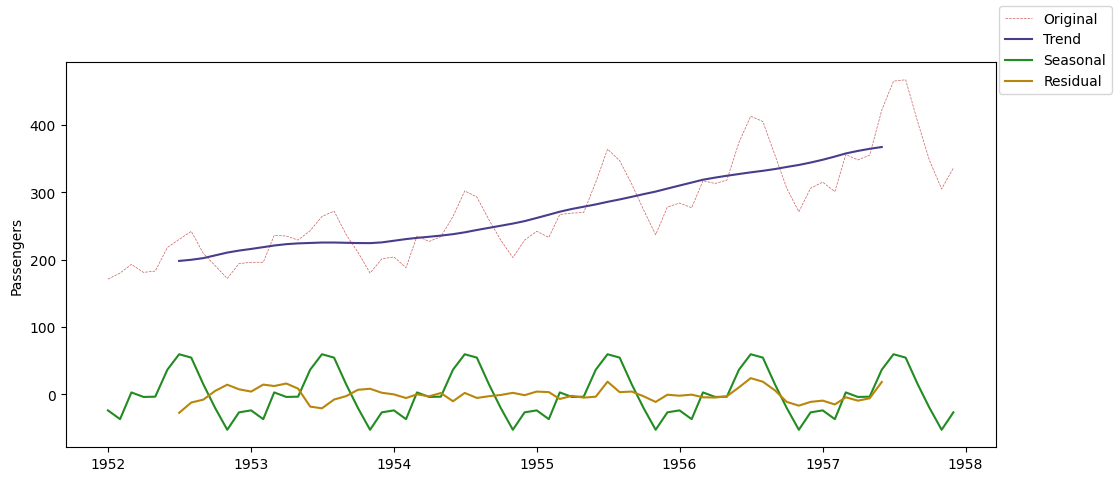

In [142]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

ax.plot(df['#Passengers'], c='indianred', linewidth=0.5, linestyle='--', label='Original')
ax.plot(decomposed.trend, c='darkslateblue', label='Trend')
ax.plot(decomposed.seasonal, c='forestgreen', label='Seasonal')
ax.plot(decomposed.resid, c='darkgoldenrod', label='Residual')
ax.set_ylabel('Passengers')

fig.legend()

Hаблюдается тренд увеличения числа пассажиров.Сезонность очевидна. 

Всплеск приходится на 3 квартал каждого года.

Временной ряд нестационарный.

In [143]:
acf = sm.tsa.acf(df['#Passengers'])

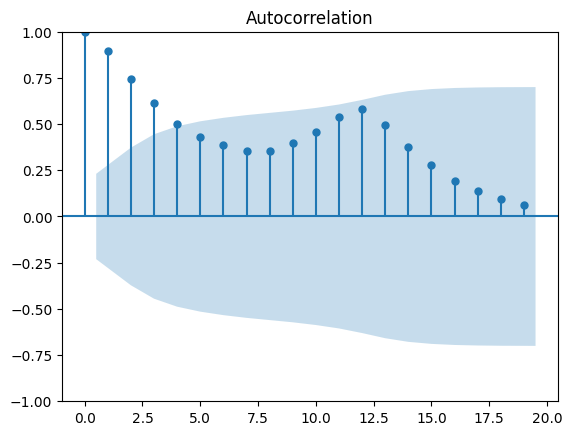

In [144]:
fig = tsaplots.plot_acf(df['#Passengers'])
plt.show() 

Во временном ряду наблюдается положительный  тренд , автокорреляция это  подтверждает.   Наибольшая автокорреляция наблюдается у первых сдвигов

3. Подготовьте данные к обучению линейной модели

3.1 Напишите функцию, которая будет генерировать новые признаки (календарные признаки, несколько колонок с разными сдвигами, несколько колонок с разными скользящими средними)

3.1.1  Воспользуйтесь наработками из скринкастов.3

3.1.2 Добавьте аргумент, который будет отвечать за возможные сдвиги. Это должен быть список, по которому в цикле будет добавляться новая колонка lag_n, где n — число из этого списка, отвечающее за сдвиг.

3.1.3 Добавьте аргумент, который будет отвечать за возможные размеры скользящего среднего. Это должен быть список, по которому в цикле будет добавляться новая колонка rolling_mean_m, где m — число из этого списка, отвечающее за размер окна, по которому вычисляется среднее. Не забудьте, что скользящее среднее нужно сдвигать, чтобы не было «заглядывания в будущее».

3.2 Рассчитайте новые признаки с помощью реализованной функции, подав ей на вход произвольные параметры генерации новых признаков.

3.3 Удалите наблюдения с пропусками в новых переменных.

3.4 Разделите данные на признаки и целевую переменную.

3.5 Разделите данные на обучающую и валидационную части. Не забудьте, что валидационная часть должна идти строго после обучающей.

In [145]:
def make_features(df, max_lag, rolling_mean_max_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    
    for i in range(1, max_lag + 1):
        df[f'lag_{i}'] = df['#Passengers'].shift(i)
        
    for i in range(2, rolling_mean_max_size + 1):
        df[f'rolling_mean_{i}'] = df['#Passengers'].rolling(i).mean().shift(1)
    
    return df

In [146]:
df_with_features = make_features(df[['#Passengers']].copy(), 14, 14)
df_with_features.head(5).T

Month,1952-01-01,1952-02-01,1952-03-01,1952-04-01,1952-05-01
#Passengers,171.00,180.00,193.00,181.00,183.00
year,1952.00,1952.00,1952.00,1952.00,1952.00
month,1.00,2.00,3.00,4.00,5.00
quarter,1.00,1.00,1.00,2.00,2.00
lag_1,NaN,171.00,180.00,193.00,181.00
lag_2,NaN,NaN,171.00,180.00,193.00
lag_3,NaN,NaN,NaN,171.00,180.00
lag_4,NaN,NaN,NaN,NaN,171.00
lag_5,NaN,NaN,NaN,NaN,NaN
lag_6,NaN,NaN,NaN,NaN,NaN


In [147]:
train, test = train_test_split(df_with_features.dropna(), shuffle=False, test_size=0.2)
train = train.dropna()
train.shape

(46, 31)

In [148]:
train_target = train['#Passengers']
train_features = train.drop(['#Passengers'], axis=1)
test_target = test['#Passengers']
test_features = test.drop(['#Passengers'], axis=1)

scaler = StandardScaler().fit(train_features)
train_features_norm = scaler.transform(train_features)
test_features_norm = scaler.transform(test_features)

4. Обучите линейную модель машинного обучения и оцените ее качество

4.1  Обучите линейную модель на обучающей части данных.

4.2 Рассчитайте значение метрики качества MAE на обучающей и валидационных частях. Если модель работает плохо (метрика выше 20), попробуйте выделить другой набор признаков, вызывая свою функцию с новыми параметрами.

4.3  Визуализируйте реальный временной ряд и прогнозные значения. 

In [149]:
mod = LinearRegression()
mod .fit(train_features_norm, train_target)

train_prediction = pd.Series(model.predict(train_features_norm))
train_prediction.index = train_features.index
test_prediction = pd.Series(model.predict(test_features_norm))
test_prediction.index = test_features.index

print("MAE обучающей выборки:" ,mean_absolute_error(train_target, train_prediction))
print("MAE тестовой выборки: " ,mean_absolute_error(test_target, test_prediction))

MAE обучающей выборки: 6.664393457152784
MAE тестовой выборки:  4.691189229683597


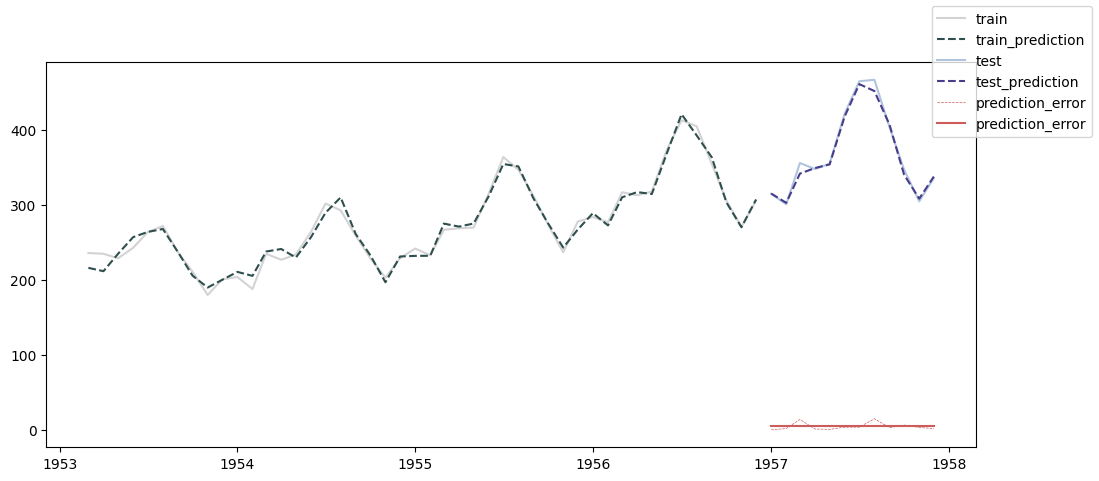

In [150]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

error = abs(test['#Passengers'] - test_prediction)
error_mean = pd.Series([error.mean()] * error.shape[0])
error_mean.index = test.index

ax.plot(train_target, c='lightgrey', label='train')
ax.plot(train_prediction, c='darkslategrey', label='train_prediction', linestyle='--')
ax.plot(test_target, c='lightsteelblue', label='test')
ax.plot(test_prediction, c='darkslateblue', label='test_prediction', linestyle='--')
ax.plot(error, c='indianred', linestyle='--', label='prediction_error', linewidth=0.5)
ax.plot(error_mean, c='indianred', label='prediction_error')

fig.legend()

5. Оцените качество модели на отложенной выборке. В качестве отложенной выборки у нас будут наблюдения с 1958 по 1960 год

5.1 Возьмите из источника необходимый срез данных.

5.2 Подготовьте данные к прогнозированию.

5.2.1 Добавьте признаки с помощью реализованной ранее функции.

5.2.2 Удалите наблюдения с пропусками.

5.2.3 Если после удаления у вас осталось менее 36 наблюдений, откорректируйте срез из пункта 5.а.

5.3 Отделите целевую переменную от признаков.

5.4  Постройте прогноз с помощью обученной ранее линейной модели.

5.5  Рассчитайте значение метрики качества на отложенной выборке.

5.6  Визуализируйте реальный временной ряд и прогнозные значения.

6. Значение метрики MAE на отложенной выборке должно быть не более 35

In [151]:
df_del = data['1956':'1960']

In [152]:
df_del_with_features = make_features(df_del[['#Passengers']].copy(), 14, 14)
df_del_with_features.head()

,#Passengers,year,month,quarter,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,rolling_mean_5,rolling_mean_6,rolling_mean_7,rolling_mean_8,rolling_mean_9,rolling_mean_10,rolling_mean_11,rolling_mean_12,rolling_mean_13,rolling_mean_14
Month,,,,,,,,,,,,,,,,,,,,,
1956-01-01,284,1956,1,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1956-02-01,277,1956,2,1,284.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1956-03-01,317,1956,3,1,277.00,284.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1956-04-01,313,1956,4,2,317.00,277.00,284.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1956-05-01,318,1956,5,2,313.00,317.00,277.00,284.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [154]:
df_del_with_features.dropna(inplace=True)
df_del_with_features.shape

(46, 31)

In [157]:
target = df_del_with_features['#Passengers']
features = df_del_with_features.drop(['#Passengers'], axis=1)

features_norm = scaler.transform(features)

In [161]:
prediction = pd.Series(mod.predict(features_norm))
prediction.index = features.index

print("MAE отложенной выборки: " , mean_absolute_error(target, prediction))

MAE отложенной выборки:  9.478433850554858


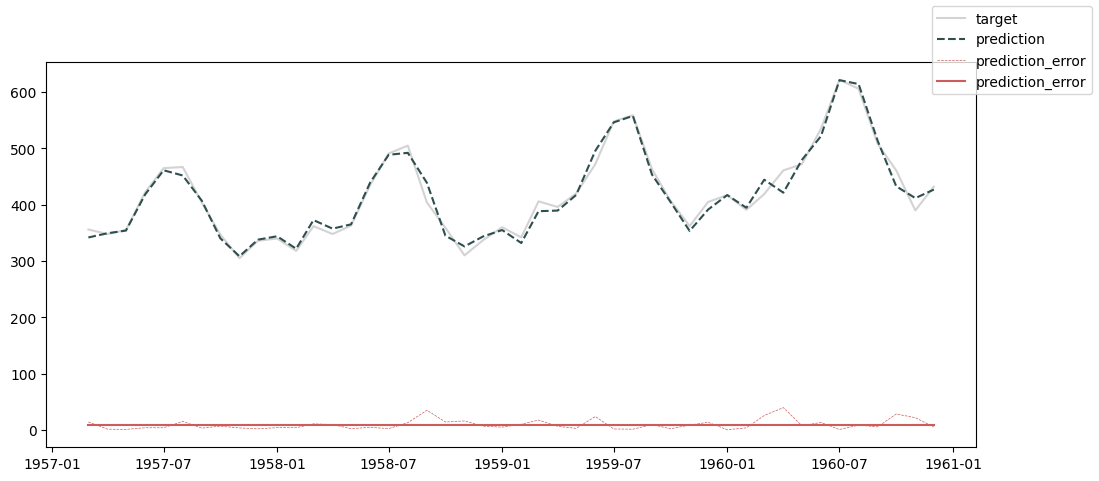

In [162]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

error = abs(target - prediction)
error_mean = pd.Series([error.mean()] * error.shape[0])
error_mean.index = target.index

ax.plot(target, c='lightgrey', label='target')
ax.plot(prediction, c='darkslategrey', label='prediction', linestyle='--')
ax.plot(error, c='indianred', linestyle='--', label='prediction_error', linewidth=0.5)
ax.plot(error_mean, c='indianred', label='prediction_error')

fig.legend()

Модель обучена качественно со следующими показателями:
- MAE обучающей выборки: 6.6643934571527765
- MAE тестовой выборки:  4.691189229683597
- MAE отложенной выборки:  9.478433850554838